# Wind Farm Model

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import time as time
import pyarrow as pa
import dask.dataframe as dd
import dask.array as da
from dask.distributed import Client
import dask
import gc
import cartopy
import cartopy.crs as ccrs
import bottleneck
import haversine as hs
from mpl_toolkits.axes_grid1 import make_axes_locatable
from global_land_mask import globe
import csv
from collections import defaultdict
import collections
import scipy.stats

In [2]:
#importing dataset
paths = ['./data/netcdf/80m_full_file.nc']
#chunked one
#ds = xr.open_mfdataset(paths, parallel=True,chunks={'latitude': -1, 'longitude': -1, 'time': -1} ,concat_dim='time', data_vars='minimal',combine='nested',coords='minimal',compat='override')
#ds = xr.open_mfdataset(paths, parallel=True,concat_dim='time', data_vars='minimal',combine='nested',coords='minimal',compat='override')
ds = xr.open_mfdataset(paths,concat_dim='time', data_vars='minimal',combine='nested',coords='minimal',compat='override').compute()
#ds = xr.open_dataset(paths,engine='netcdf4')

## Setting Coordinates of Wind Farms

In [3]:
#Group 0
coords = np.empty((4,5,2))
coords[0,0,:] = np.array([55, 2.0])
coords[0,1,:] = np.array([54.5, -4.3])
coords[0,2,:] = np.array([50.4, -1.3])
coords[0,3,:] = np.array([58.0, -6.0])
coords[0,4,:] = np.array([51.8, 1.5])

#Group 1
lat = 55
lon = 2.0
coords[1,0,:] = np.array([lat+0.25, lon])
coords[1,1,:] = np.array([lat, lon+0.25])
coords[1,2,:] = np.array([lat, lon-0.25])
coords[1,3,:] = np.array([lat+0.25, lon-0.25])
coords[1,4,:] = np.array([lat+0.25, lon+0.25])

#Group 2
lat = 50.4
lon = -1.3
coords[2,0,:] = np.array([lat+0.25, lon])
coords[2,1,:] = np.array([lat, lon+0.25])
coords[2,2,:] = np.array([lat, lon-0.25])
coords[2,3,:] = np.array([lat+0.25, lon-0.25])
coords[2,4,:] = np.array([lat+0.25, lon+0.25])

#Group 4
coords[3,0,:] = np.array([51., -2.5])
coords[3,1,:] = np.array([53., -4.])
coords[3,2,:] = np.array([54.75, -1.])
coords[3,3,:] = np.array([52., 0.])
coords[3,4,:] = np.array([57., -4.])

coords = (np.round(coords*4, decimals=0)/4)
print(coords)
#color = ['r','b','g']
color = ['r','b','g','m']

[[[55.    2.  ]
  [54.5  -4.25]
  [50.5  -1.25]
  [58.   -6.  ]
  [51.75  1.5 ]]

 [[55.25  2.  ]
  [55.    2.25]
  [55.    1.75]
  [55.25  1.75]
  [55.25  2.25]]

 [[50.75 -1.25]
  [50.5  -1.  ]
  [50.5  -1.5 ]
  [50.75 -1.5 ]
  [50.75 -1.  ]]

 [[51.   -2.5 ]
  [53.   -4.  ]
  [54.75 -1.  ]
  [52.    0.  ]
  [57.   -4.  ]]]


## Work Out Number of Turbines per grid space

Use a whole 30km x 30km grid space, assume power density of 6MW/km$^2$. Assume using 8MW turbines.

Use a grid space, of which size decreases as latitude increases, at most northernly point of orkney at 61$\degrees$ N, grid point is around 13.5km x 27.5km.

In [4]:
grdpnt_power = 30*30*6
turbine_rating = 8 #MW
n_turbs_grdpnt = grdpnt_power/turbine_rating
loss_factor = 0.9 #energy lost due to wind turbines in farms

grdpnt_power = 13.5*27.5*6
turbine_rating = 8 #MW
n_turbs_grdpnt = grdpnt_power/turbine_rating
loss_factor = 0.9 #energy lost due to wind turbines in farms


print('Total Power:',grdpnt_power,'MW per grid point')
print('Turbine Rating:',turbine_rating,'MW')
print('Number of Turbines per grid point:',int(n_turbs_grdpnt))

Total Power: 2227.5 MW per grid point
Turbine Rating: 8 MW
Number of Turbines per grid point: 278


## Creating Dataset Variable of aggregate power

In [5]:
#over all time points for power stations grouped together
agg_power = dict()
for i in range(coords.shape[0]):
    lats = xr.DataArray(coords[i,:,0], dims='coords')
    lons = xr.DataArray(coords[i,:,1], dims='coords')
    agg_power[i] = ((ds['power']
                     .sel(latitude = lats, longitude = lons)*n_turbs_grdpnt*loss_factor)
                    .sum(dim='coords')).compute()

## Calculate Aggregate Firm Capacity

In [8]:
#calculating firm capacity
N = 1000 #number of samples
ratios = np.linspace(0,1.0,N)
#ratios = np.array([0.3,0.4,0.5]) #delete this later
power_limit = ratios * 8000 * n_turbs_grdpnt * coords.shape[1]
#print(8000 * n_turbs_grdpnt * coords.shape[1]*1e-6,'Gw')
firm_capacity = np.empty((coords.shape[0],ratios.shape[0]))
arr_length = agg_power[0].shape[0]

for j in range(coords.shape[0]):
    start= time.time()
    for i, ratio in enumerate(ratios):
        working_ds = agg_power[j]
        val = working_ds.where(working_ds>=power_limit[i]).count(dim='time').values
        firm_capacity[j,i] = val/arr_length #proportion of values above the power limit
    end = time.time()
    print(j,') Time taken for',ratios.shape[0],'calculations:',np.round((end-start),decimals=2),'secs')
    #print(firm_capacity[j,:])

0 ) Time taken for 1000 calculations: 1.56 secs
1 ) Time taken for 1000 calculations: 1.64 secs
2 ) Time taken for 1000 calculations: 1.62 secs
3 ) Time taken for 1000 calculations: 1.55 secs


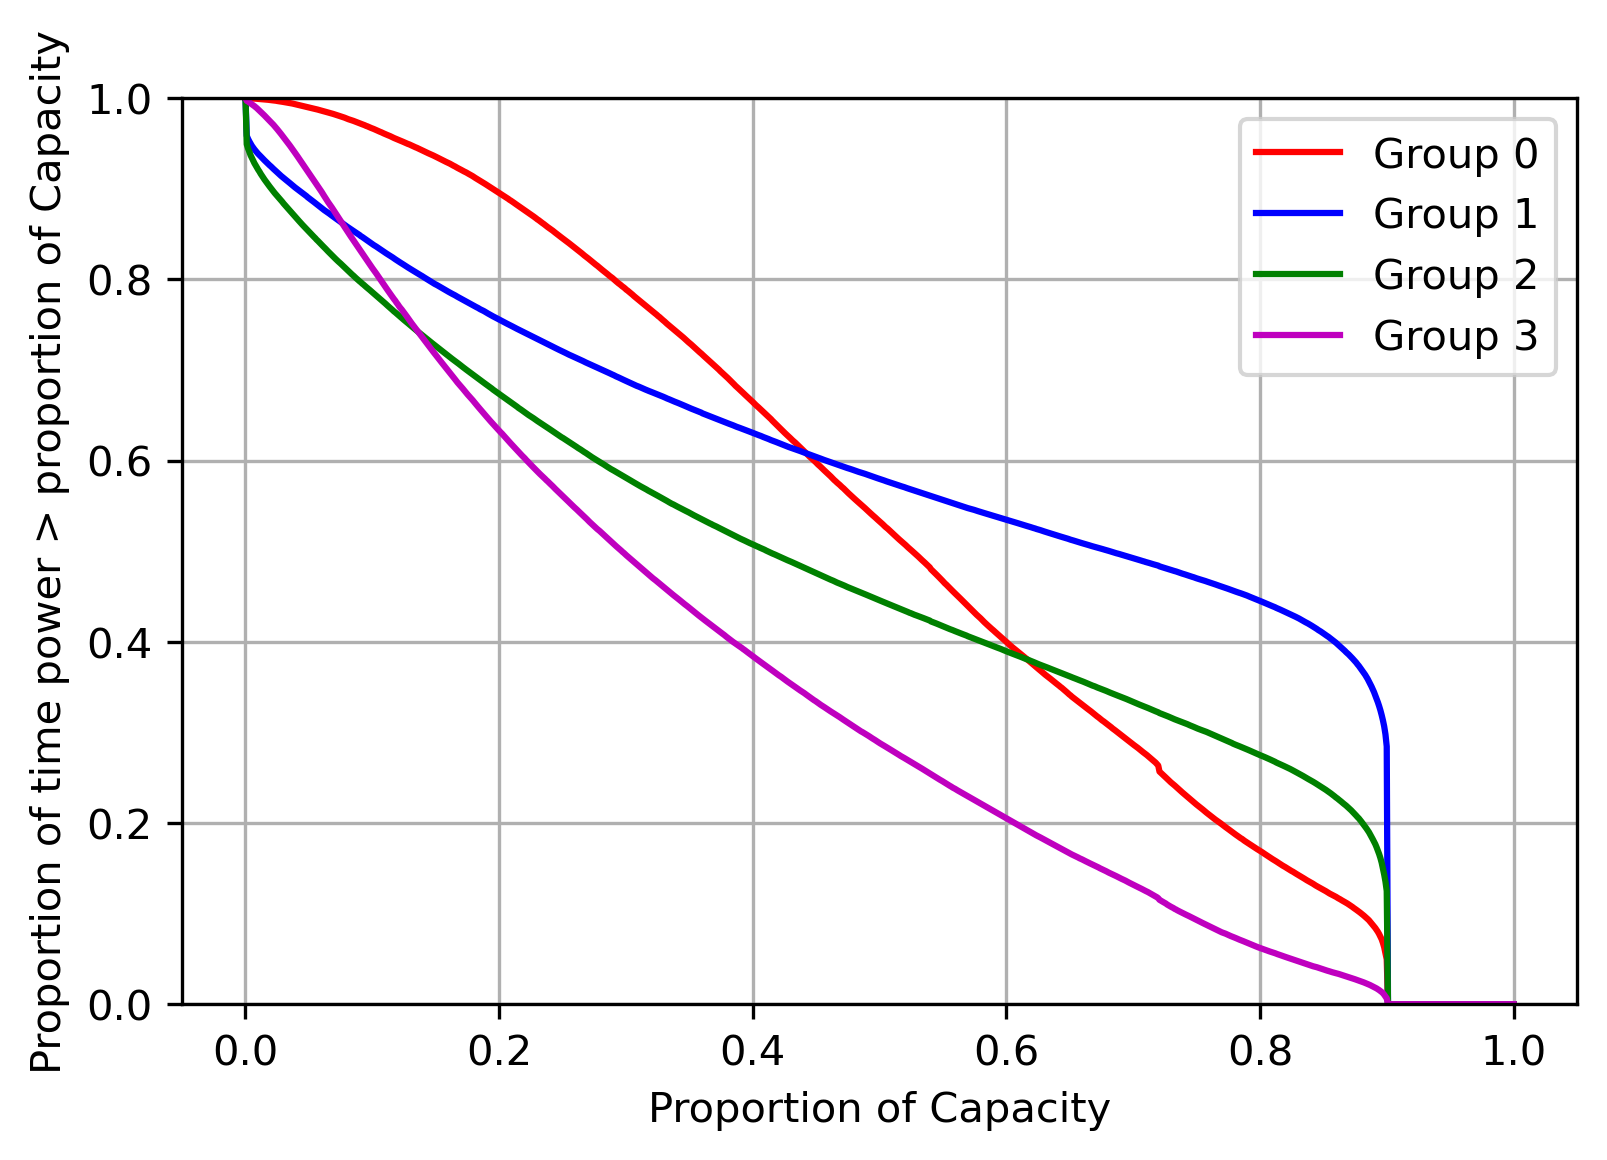

In [9]:
scale = 1e-6 #converts kW to GW
plt.figure(dpi=300)
for j in range(coords.shape[0]):
    plt.plot(ratios, firm_capacity[j,:],label=f'Group {j}',color=color[j])
plt.ylim(0,1)
#plt.axvline(x= 0.9, color='red',linestyle='--',linewidth=0.4)
plt.title('Firm Capacity over a range')
plt.title('')
plt.xlabel('Proportion of Capacity')
plt.ylabel('Proportion of time power > proportion of Capacity')
plt.legend()
plt.grid()

plt.savefig('./figures/firm_capacity_range.pdf',bbox_inches='tight')

It makes sense that Group 1 which is geographically separated has the lowest proportion at the Max Power Limit, this is because for a single location there will always be times where vrated < v < v-cutoff. This can be given by fractional likelihood say 1/10, as the wind farms are spread out they become semi-independent and therefore the chance all wind speeds sit in the 'sweet spot' is (1/10)^4, much smaller than the 1/10 of the dependent and close together wind turbines.

The upshot of separation of wind turbines come from the same argument, the chance they all have no wind is very low and therefore they Group 0 has a higher proportion of time at the lower end of the power limits as it is less likely that all 4 semi-independent wind turbines experience low wind than 4 depent wind turbines.

AIM: Maximise this beginning of the S-curve seen in Group 0 such that it gives the a larger amount power 100% of the time. Done by creating wind farms at sites with lower correlations.

From this is would be useful to do an analysis of correlation of wind speeds around the UK to try to minimise correlations and maybe even find negative correlations.


### FOM of Power Capacity

Below a FOM is created from the average of the proportion of time power output is spent above, 20,30,40 & 50% of capacity. Want to maximise this value.

In [12]:
FOM_prop = np.zeros(coords.shape[0])
print('FOM_prop:')
for i in range(coords.shape[0]):
    FOM_prop[i] = np.average(firm_capacity[i, 2:6]) 
    print(f'Group {i}:',np.round(FOM_prop[i],decimals=2))

FOM_prop:
Group 0: 1.0
Group 1: 0.95
Group 2: 0.94
Group 3: 0.99


## Plotting Locations of the Wind Farms

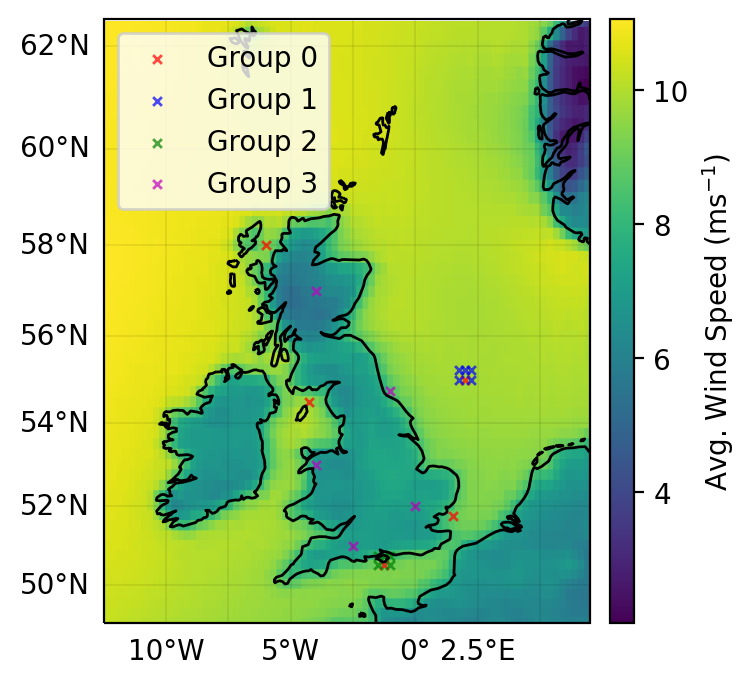

In [13]:
ds_mean = ds.mean(dim='time')['wind_mag'].transpose()
edge =-0.1

#plotting
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.Mercator()), dpi=200)
#plt.figure(dpi=250)
ax = plt.axes(projection=ccrs.Mercator())
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='black', alpha=0.5 )
gl.top_labels = False
gl.right_labels = False
plt.title('Wind Farm Locations')
plt.title('')
ax.set_extent([ds.coords['longitude'][0], ds.coords['longitude'][-1],ds.coords['latitude'][0], ds.coords['latitude'][-1]], ccrs.PlateCarree())
ax.coastlines(resolution='50m')
for j in range(coords.shape[0]):
    plt.scatter(x=coords[j,:,1], y=coords[j,:,0],marker='x', color=color[j], s=10, alpha=.7,transform=ccrs.PlateCarree(),linewidth=1) 
classes = ['Group 0', 'Group 1', 'Group 2', 'Group 3']
plt.legend(loc='upper left', labels=classes)



img_extent = ([ds.coords['longitude'][0], ds.coords['longitude'][-1],ds.coords['latitude'][0]-edge, ds.coords['latitude'][-1]+edge])
z = ax.imshow(ds_mean, origin='lower', extent=img_extent, transform = ccrs.PlateCarree())

divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="5%", pad=0.1, axes_class=plt.Axes)

fig.add_axes(ax_cb)
plt.colorbar(z, cax=ax_cb, label=r'Avg. Wind Speed (ms$^{-1}$)')

    
plt.savefig('./figures/wind_farm_locs.pdf',bbox_inches='tight')

### Identifying onshore points

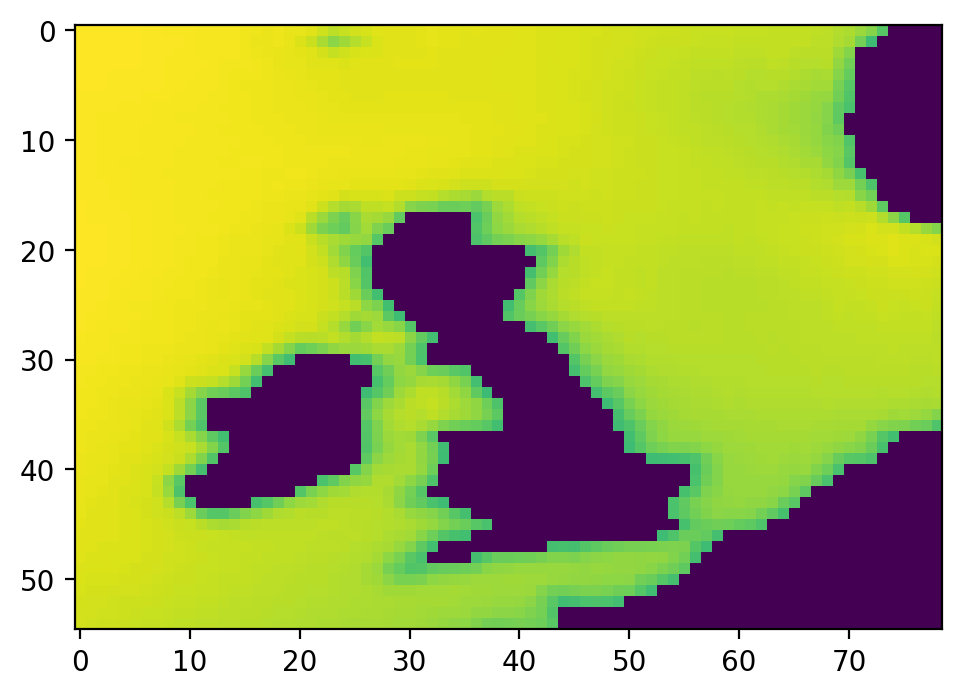

In [10]:
#showing outline of avg speed < 6m/s
ds_mean_limit = np.where(ds_mean < 7.6,0,ds_mean)
plt.figure(dpi=200)
plt.imshow(ds_mean_limit)

## Capacity Factors

Plotting the capacity factors of all of the indivudal wind turbine farm locations.

In [14]:
cap_fac_store = np.zeros((4,5))

print('Capacity factors:')
for j in range(coords.shape[0]):
    print('Group',j)
    for i in range(coords.shape[1]):
        ds_cpf = ds['power'].sel(latitude=[coords[j,i,0]], longitude=[coords[j,i,1]]).mean(dim='time').to_numpy()[0][0]
        print('Coords: (',coords[j,i,0],',',coords[j,i,1],f') C_f =',np.round(loss_factor*ds_cpf/80, decimals=2))
        cap_fac_store[j,i] = loss_factor*ds_cpf/80
    print('Average:',np.average(cap_fac_store[j,:]))

Capacity factors:
Group 0
Coords: ( 55.0 , 2.0 ) C_f = 56.01
Coords: ( 54.5 , -4.25 ) C_f = 53.93
Coords: ( 50.5 , -1.25 ) C_f = 49.89
Coords: ( 58.0 , -6.0 ) C_f = 52.97
Coords: ( 51.75 , 1.5 ) C_f = 49.65
Average: 52.49180786132813
Group 1
Coords: ( 55.25 , 2.0 ) C_f = 56.1
Coords: ( 55.0 , 2.25 ) C_f = 56.08
Coords: ( 55.0 , 1.75 ) C_f = 56.0
Coords: ( 55.25 , 1.75 ) C_f = 56.04
Coords: ( 55.25 , 2.25 ) C_f = 56.3
Average: 56.10637463378906
Group 2
Coords: ( 50.75 , -1.25 ) C_f = 41.14
Coords: ( 50.5 , -1.0 ) C_f = 50.97
Coords: ( 50.5 , -1.5 ) C_f = 50.17
Coords: ( 50.75 , -1.5 ) C_f = 41.32
Coords: ( 50.75 , -1.0 ) C_f = 43.52
Average: 45.42524670410156
Group 3
Coords: ( 51.0 , -2.5 ) C_f = 34.13
Coords: ( 53.0 , -4.0 ) C_f = 32.81
Coords: ( 54.75 , -1.0 ) C_f = 46.9
Coords: ( 52.0 , 0.0 ) C_f = 36.01
Coords: ( 57.0 , -4.0 ) C_f = 25.82
Average: 35.13462396240235


## Plotting Number of Lulls

In [10]:
avg_nums = np.logspace(0,2.5265,40, dtype='int') #1hr to 2 weeks
avg_nums = np.arange(1,337) #1hr to 2 weeks
start_date = '1998-01-01' #1998-01-01
end_date = '2021-12-31' #2021-12-31
num_yrs = 24 #years
cut_offs = np.array([0.01,0.1,0.2,0.4,0.5])
num_lulls = np.empty((cut_offs.shape[0],coords.shape[0],avg_nums.shape[0]),dtype='float64')


#cycle through cutoffs
for k in range(cut_offs.shape[0]):
    start = time.time()
    #cycle through coords
    max_power = turbine_rating*1000*cut_offs[k]*n_turbs_grdpnt*coords.shape[1] #max power to be considered a lull
    for j in range(coords.shape[0]):
    
        #cycle through avgs
        for i, num_hours in enumerate(avg_nums):
            working_ds = (agg_power[j].sel(time=slice(start_date, end_date))
                          .rolling(time=num_hours)
                          .mean())

            num = (working_ds.where(working_ds < max_power))
            num_next = num.where((num.shift(time=+1).isnull() != False) & (num.shift(time=-1).isnull() != False))
            num_lulls[k,j,i] = num_next.count(dim='time').values 
            
            #old version
            #num_lulls[k,j,i] = (working_ds.where(working_ds < max_power).count(dim='time').values)
    
    end = time.time()
    print(k,', Time taken:',np.round(end-start,decimals=3),'secs')
        #print('Group:(',k,',',j,')) Time taken for',avg_nums.shape[0],'calculations:',np.round((end-start),decimals=2),'secs')

0 , Time taken: 9.321 secs
1 , Time taken: 9.259 secs
2 , Time taken: 10.253 secs
3 , Time taken: 9.479 secs
4 , Time taken: 9.323 secs


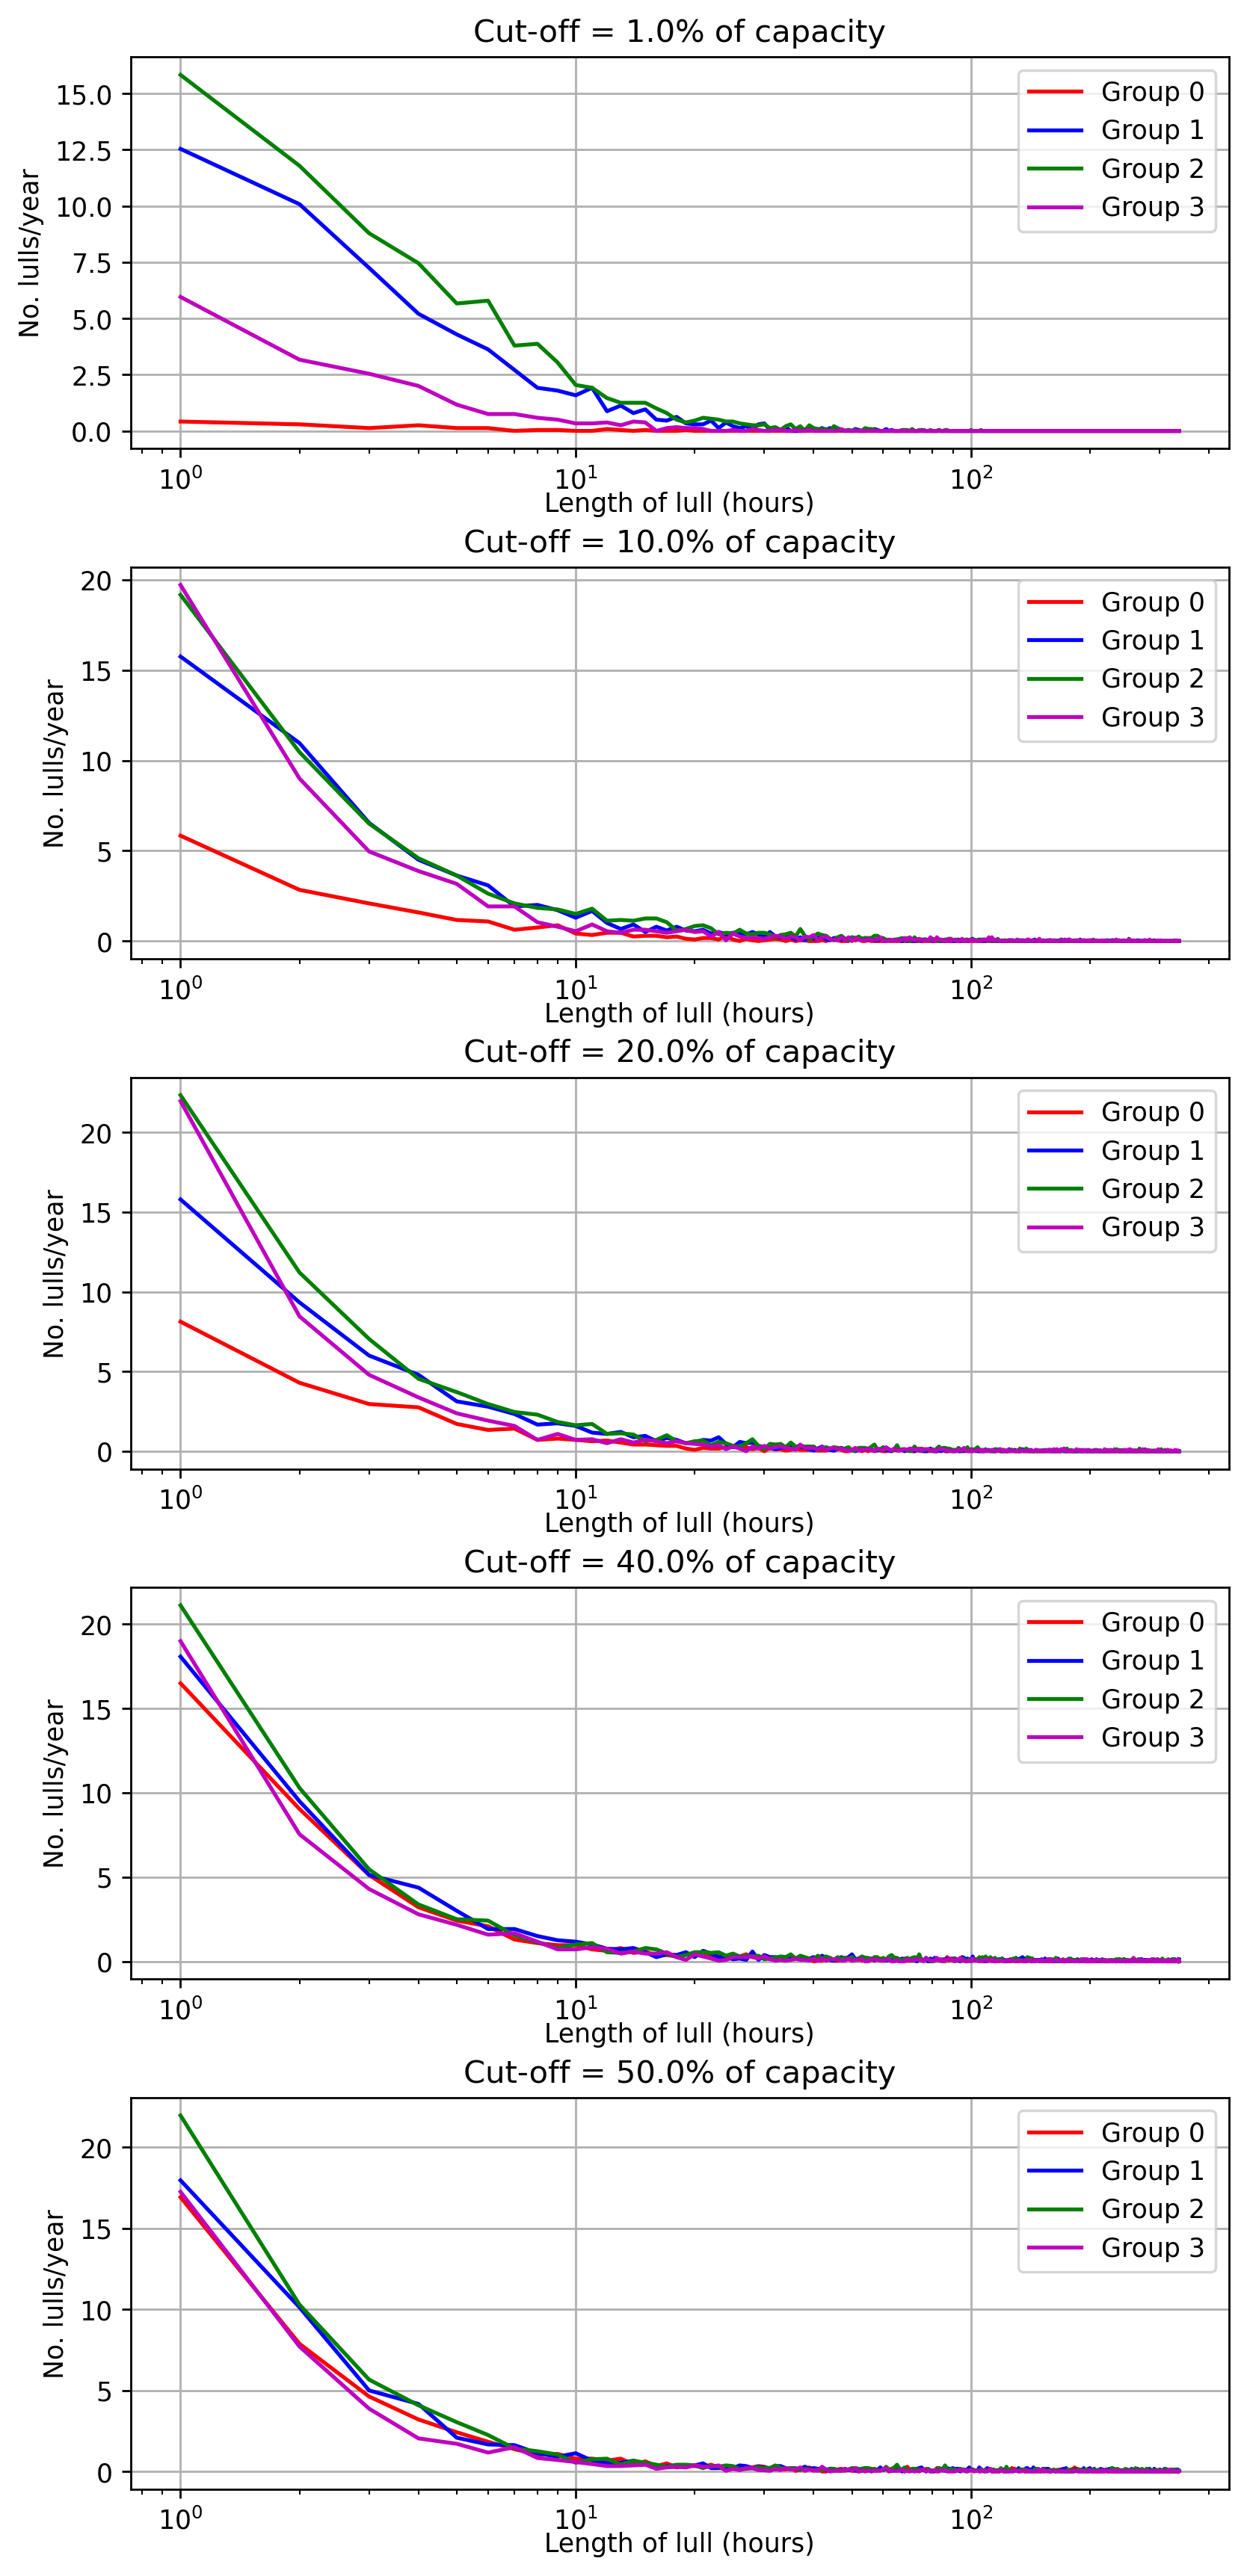

In [16]:
fig, ax = plt.subplots(5,dpi=250, figsize=(7,14))
fig.tight_layout(pad=2.5)
#plt.title(f'No. of lulls over lull duration (cut-off = {cut_offs*100}% of max power)')
for k in range(cut_offs.shape[0]):
    ax[k].set_xlabel('Length of lull (hours)',labelpad=-1)
    ax[k].set_ylabel('No. lulls/year')
    ax[k].grid()
    for j in range(coords.shape[0]):
        ax[k].semilogx(avg_nums,num_lulls[k,j,:]/num_yrs,label = f'Group {j}',color=color[j])
        ax[k].set_title(f'Cut-off = {cut_offs[k]*100}% of capacity')
    ax[k].legend()
fig.savefig('./figures/cut-off_freq.pdf',bbox_inches='tight')

### Plotting Lull frequency Histogram

/home/xzcaphbe/.conda/envs/env3.8_optimise/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/xzcaphbe/.conda/envs/env3.8_optimise/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


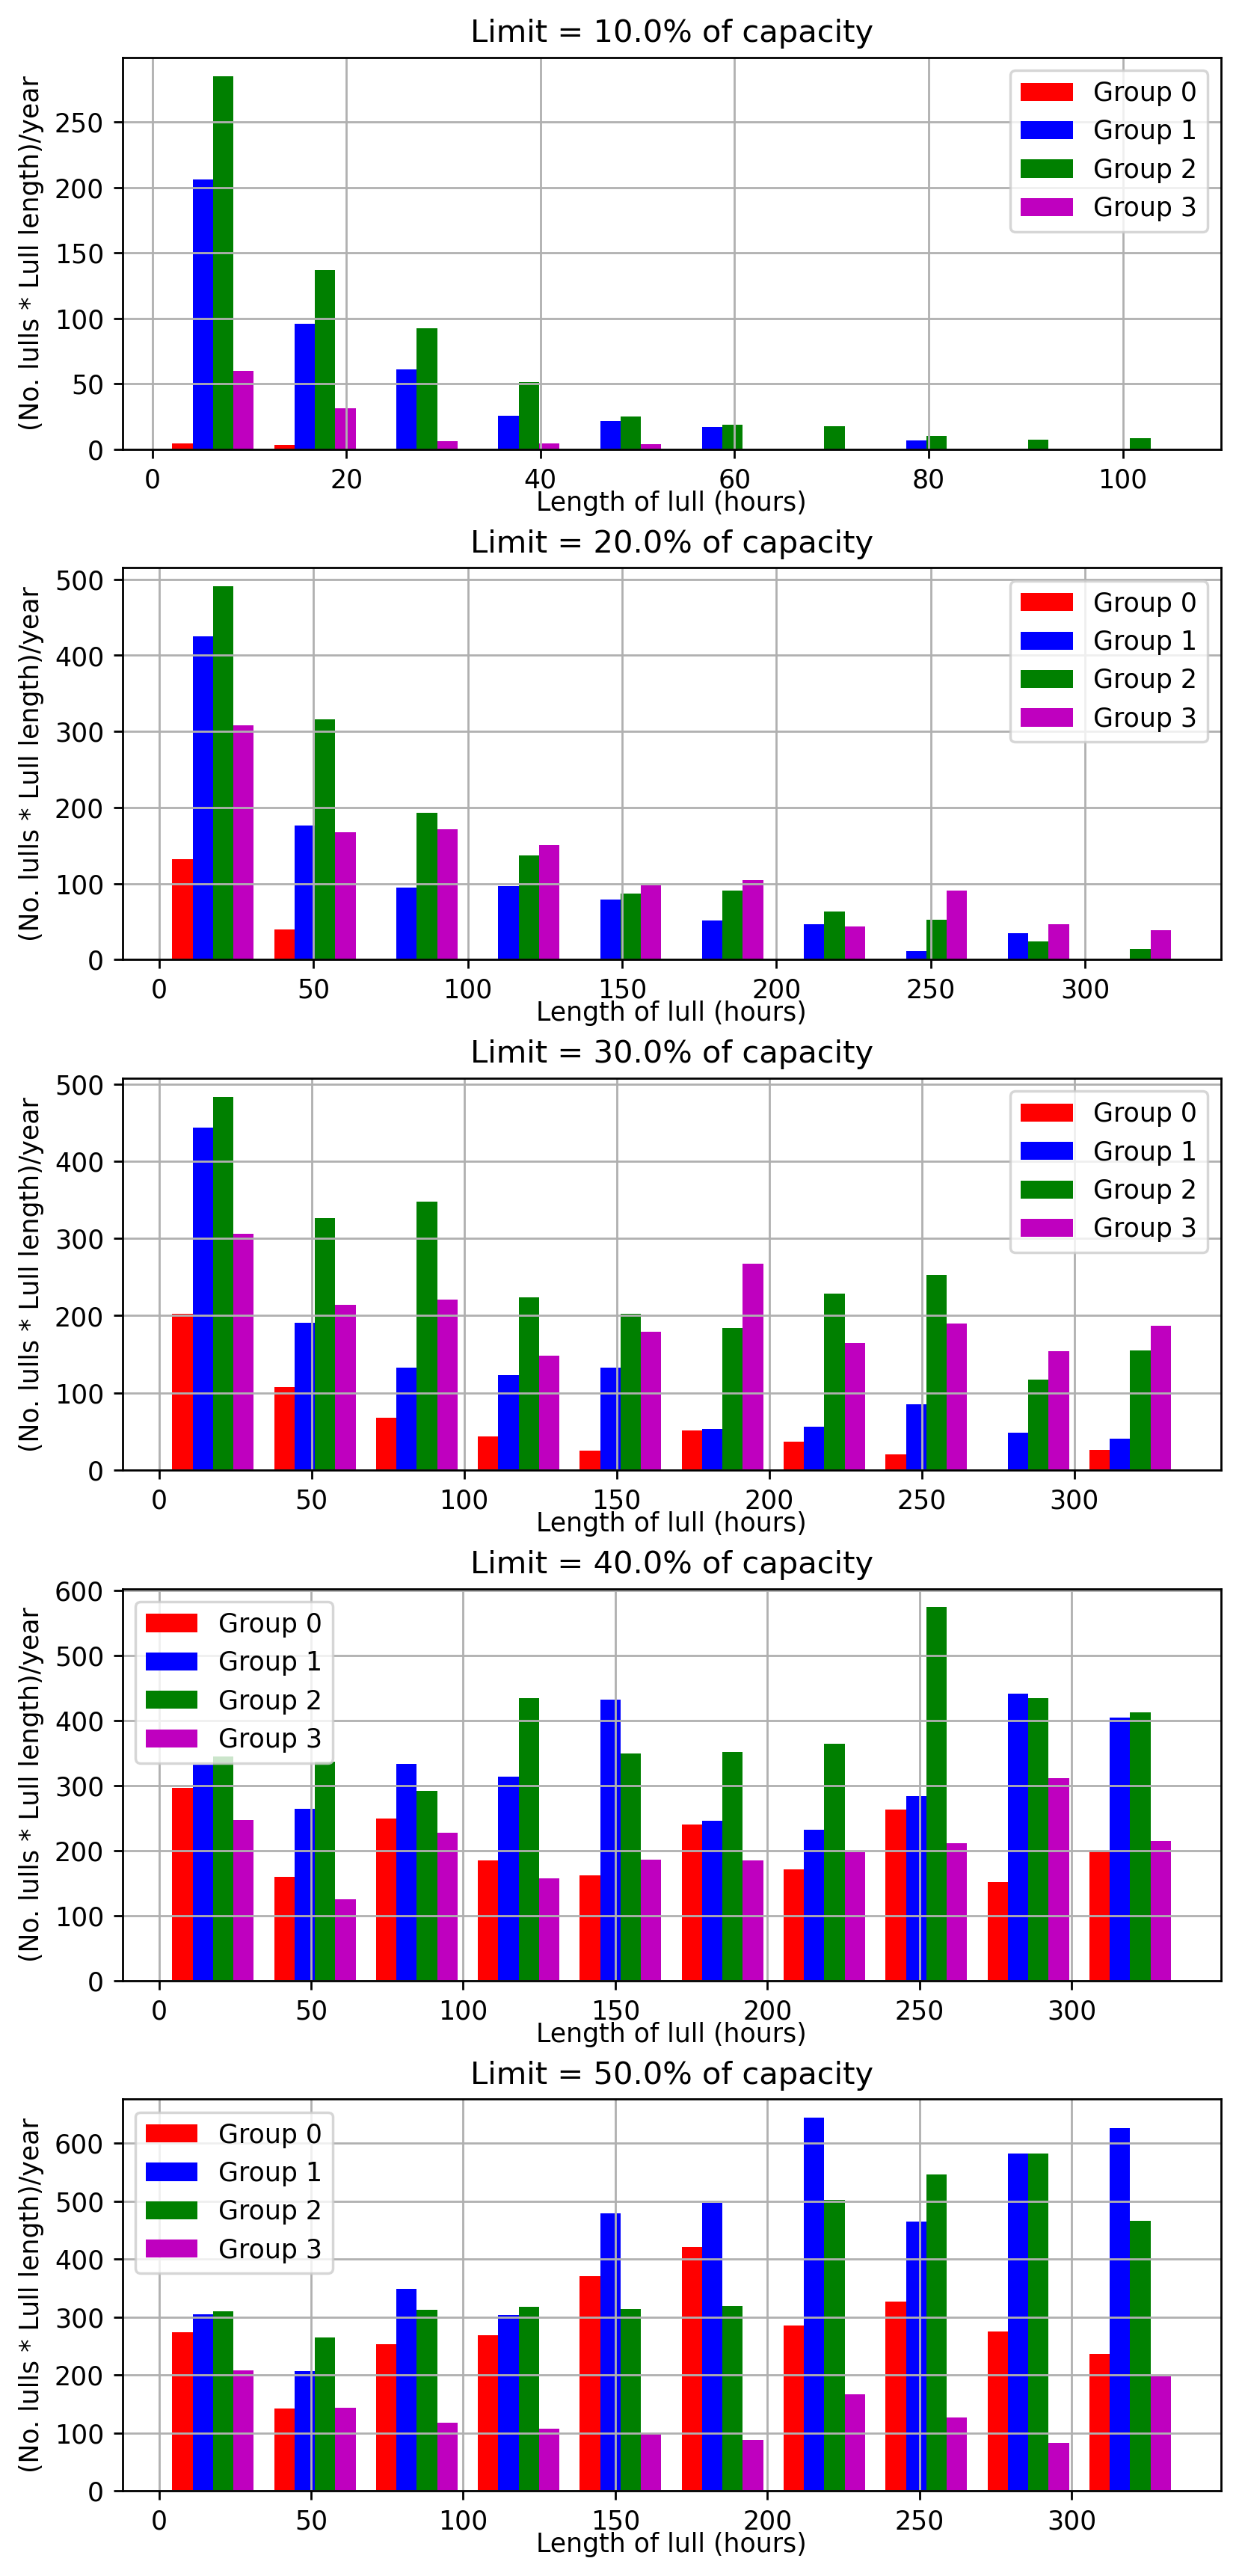

In [11]:
cut_offs = np.array([0.1,0.2,0.3,0.4,0.5])
fig, ax = plt.subplots(5,dpi=250, figsize=(7,14))
fig.tight_layout(pad=2.5)
#plt.title(f'No. of lulls over lull duration (cut-off = {cut_offs*100}% of max power)')
for k in range(cut_offs.shape[0]):
    ax[k].set_xlabel('Length of lull (hours)',labelpad=-1)
    ax[k].set_ylabel('(No. lulls * Lull length)/year')
    ax[k].grid()
    
    
    x = dict()
    
    for j in range(coords.shape[0]):   #iterate through groups
        x[j] = np.empty(0,dtype='object')
        for i in range(avg_nums.shape[0]):  #iterate through lull length
            
            arr = np.ones(int(num_lulls[k,j,i]))*(i+1)
            x[j] = np.hstack((x[j],arr))
        
        
        
        
    ax[k].hist([x[0],x[1],x[2],x[3]],weights=[x[0]/num_yrs,x[1]/num_yrs,x[2]/num_yrs,x[3]/num_yrs],
               label = ['Group 0','Group 1','Group 2','Group 3'],color=color)
    ax[k].set_title(f'Limit = {cut_offs[k]*100}% of capacity')
    ax[k].legend()
fig.savefig('./figures/lull_hist_cut_off.pdf',bbox_inches='tight')

#### Talking about 1% capacity
On a less macro scale this graph shows the number of times lulls for a range of lull lengths. Group 0 can be seen clearly to have the lowest number of lulls, which can also be explained by the logic about the probabilities of dependent and independent wind turbines explored above.

It is interesting to look at this graph to explore the short term effects of wind lulls in the UK and how they would effect daily power management.

What needs to be explored are the main problems with wind power in the UK, and to create a range of variables to measure these problems.

## Histograms of Power Outputs for each group

Group 0 average power = 5.85 GW
Group 1 average power = 6.25 GW
Group 2 average power = 5.06 GW
Group 3 average power = 3.91 GW


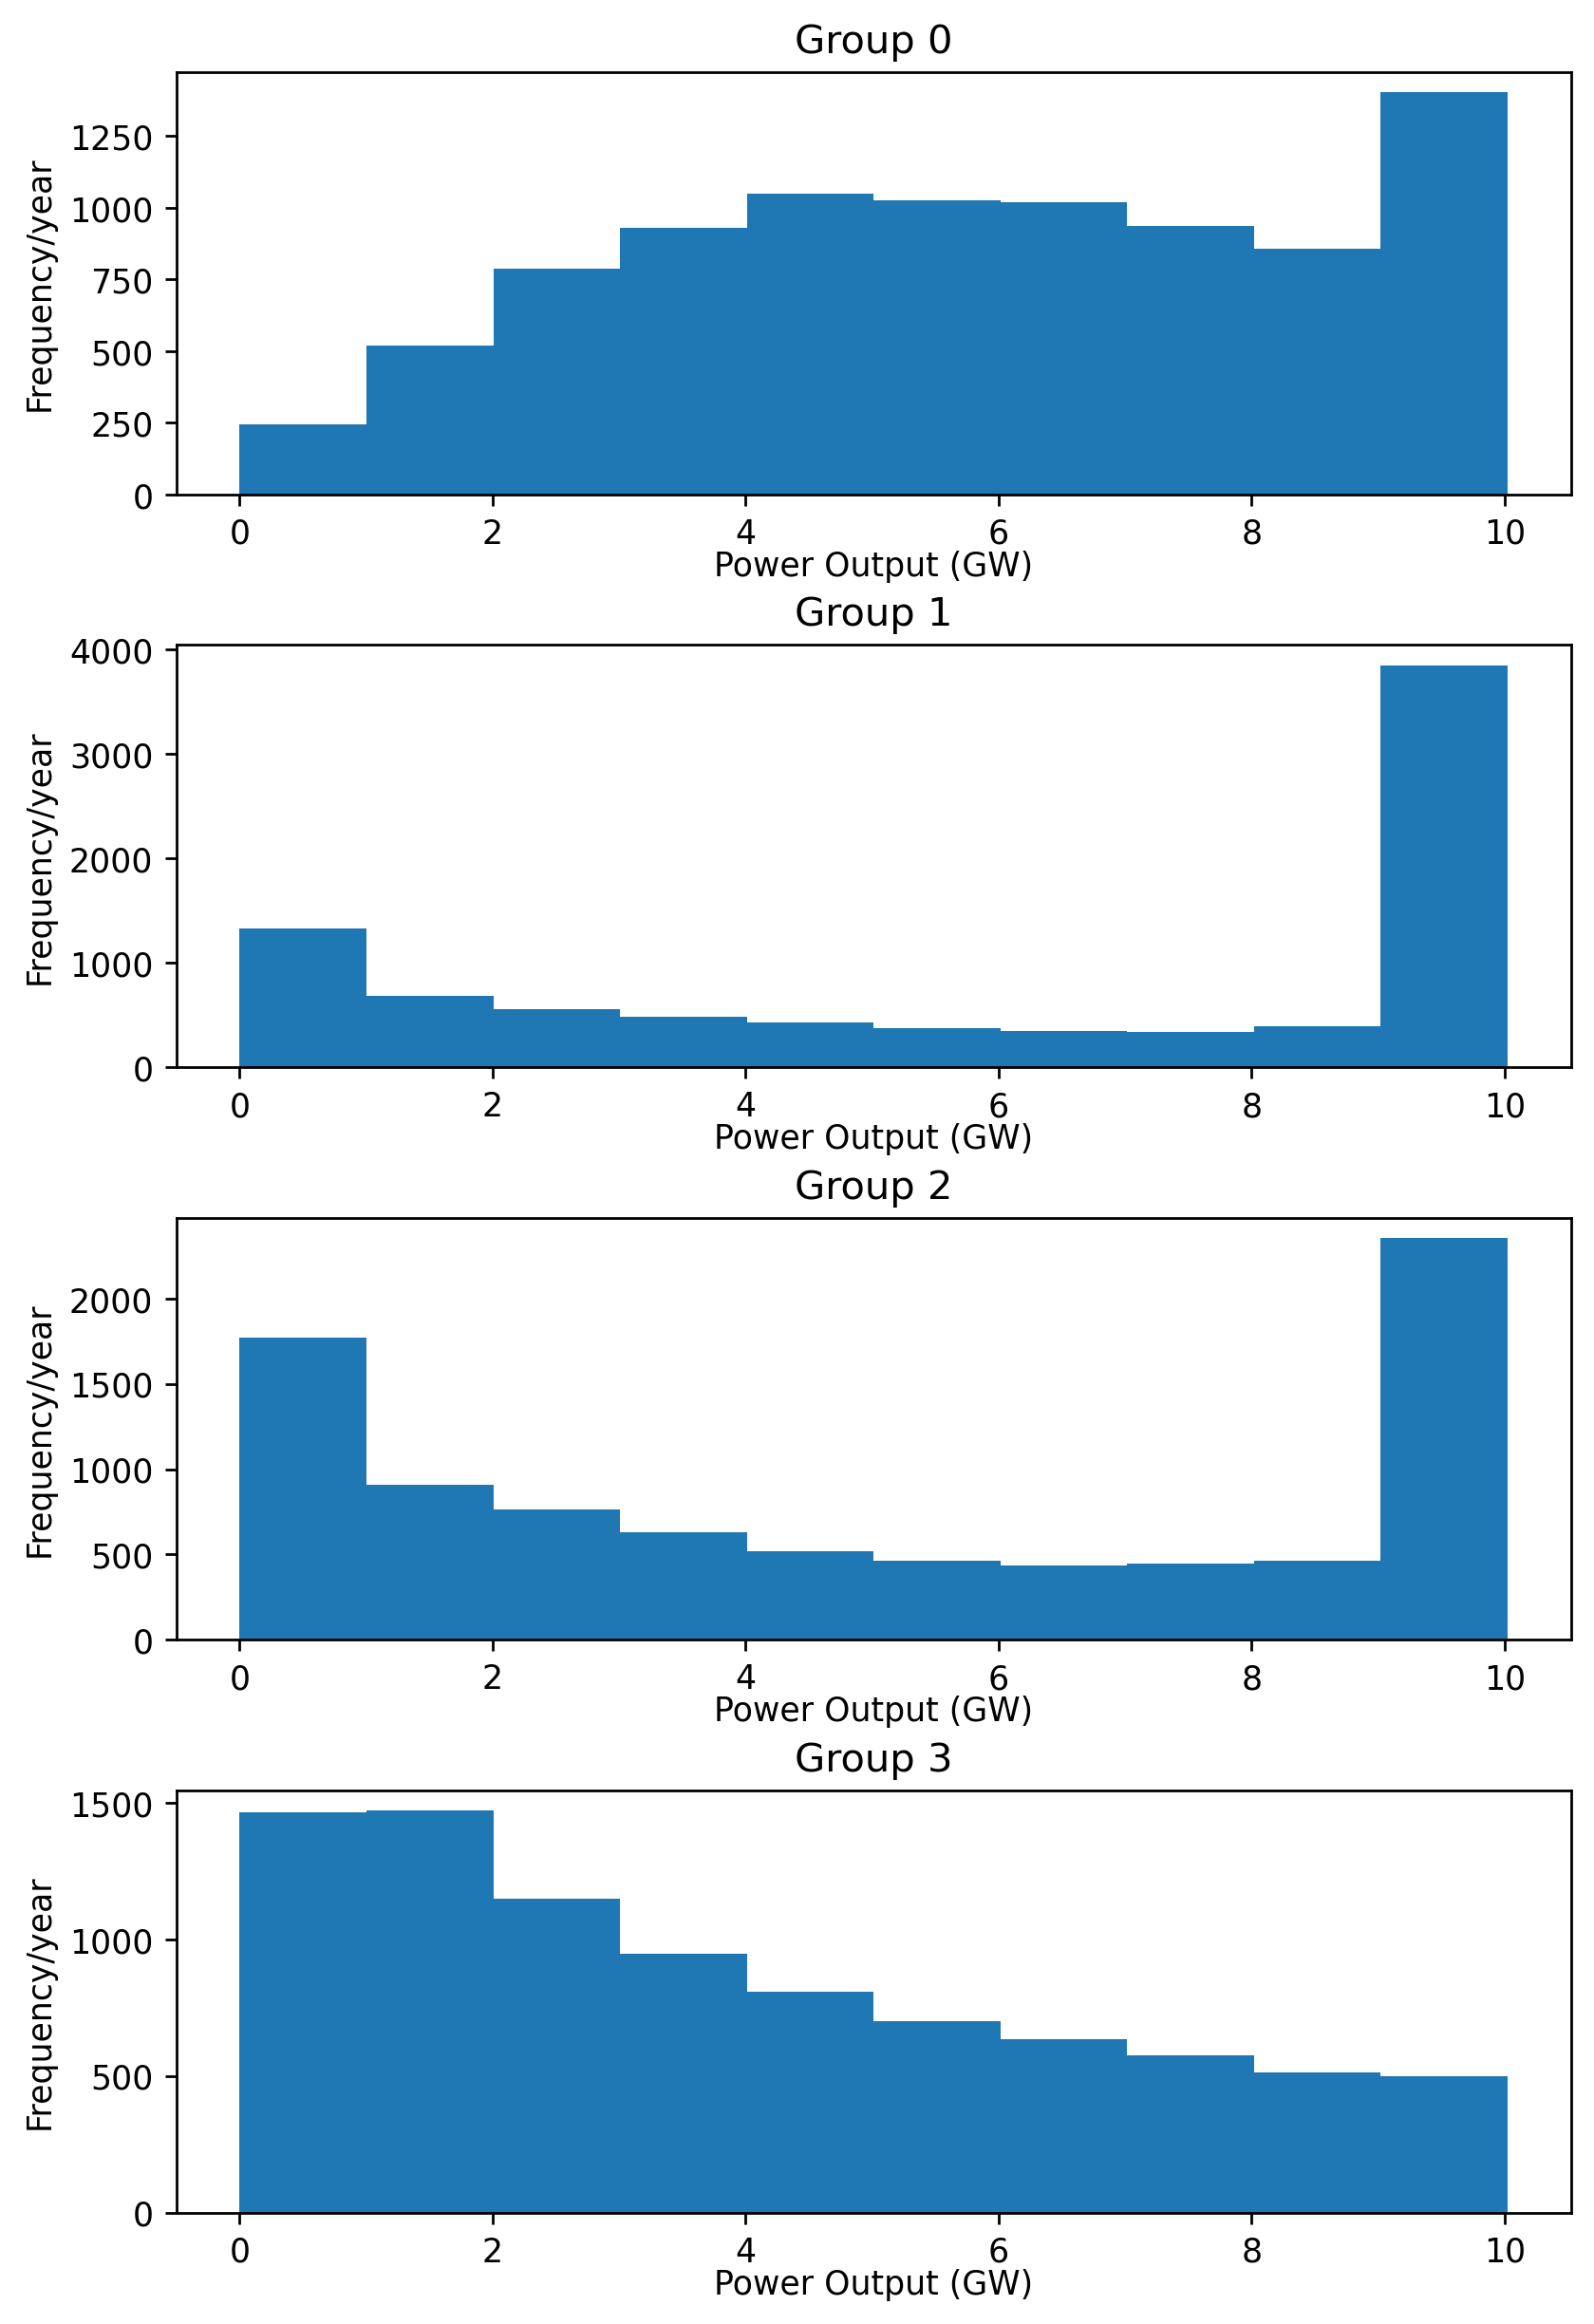

In [18]:
fig, ax = plt.subplots(4,dpi=250,figsize=(7,10))
fig.tight_layout(pad=2.5)
for i in range(coords.shape[0]):
    agg_power_GW = agg_power[i]/1e6
    agg_power_GW.plot.hist(ax =ax[i],weights=np.ones(agg_power[i].shape[0])/num_yrs) 
    ax[i].set_title(f'Group {i}')
    ax[i].set_xlabel('Power Output (GW)',labelpad=0)
    ax[i].set_ylabel('Frequency/year')
    #xticks = ax[i].get_xticks()
    #ax[i].set_xticklabels(np.round(xticks/1e6,decimals=1))
    #yticks = ax[i].get_yticks()
    #ax[i].set_yticklabels(np.round(yticks/24,decimals=1))
    print(f'Group {i} average power =',np.round(agg_power[i].mean(dim='time').compute().to_numpy()/1e6,decimals=2),'GW')
    
fig.savefig('./figures/histograms.pdf',bbox_inches='tight')

## Spearman's Rank Correlation Coefficient

In [6]:
def covariance_gufunc(x, y):
    return ((x - x.mean(axis=-1, keepdims=True)) * (y - y.mean(axis=-1, keepdims=True))).mean(axis=-1)

def pearson_correlation_gufunc(x, y):
    return covariance_gufunc(x, y) / (x.std(axis=-1) * y.std(axis=-1))

def spearman_correlation_gufunc(x, y):
    x_ranks = bottleneck.rankdata(x, axis=-1)
    y_ranks = bottleneck.rankdata(y, axis=-1)
    return pearson_correlation_gufunc(x_ranks, y_ranks)

def spearman_correlation(x, y, dim):
    return xr.apply_ufunc(
        spearman_correlation_gufunc,
        x,
        y,
        input_core_dims=[[dim], [dim]],
        dask="parallelized",
        output_dtypes=[float])

This works calculating like this for e.g. 4 points: (21 - 31,32 - 41,42,43 - 51,52,53,54)

Only problem here is that its very slow, outputting the correlation coefficient into the ranks matrix

In [20]:
combinations = 10
ranks = xr.DataArray(np.zeros((coords.shape[0],combinations)))
distances = np.zeros((coords.shape[0],combinations))

#cycle through wind farm groups
for i in range(coords.shape[0]):
    count = 0
    start = time.time()
    #cycle through wind farms
    for j in range(coords.shape[1]):
        for k in range(j):
            array1 = ds['power'].sel(latitude = coords[i,j,0], longitude = coords[i,j,1]).chunk(dict(time=-1))
            array2 = ds['power'].sel(latitude = coords[i,k,0], longitude = coords[i,k,1]).chunk(dict(time=-1))
            val = spearman_correlation(array1, array2, 'time')
            ranks[i,count] = val
            loc1=(coords[i,j,0],coords[i,j,1])
            loc2=(coords[i,k,0],coords[i,k,1])
            distances[i,count] = hs.haversine(loc1,loc2) 
            count += 1
            del array1
            del array2
    end = time.time()
    print(i,', Time taken:',np.round(end-start,decimals=3),'s')
    #print(np.round(end-start,decimals=3))
    #print(np.round(end-start,decimals=3))
    
ranks = ranks.to_numpy()

0 , Time taken: 0.707 s
1 , Time taken: 0.646 s
2 , Time taken: 0.671 s
3 , Time taken: 0.683 s


Rank avg: 0.6866897927106352


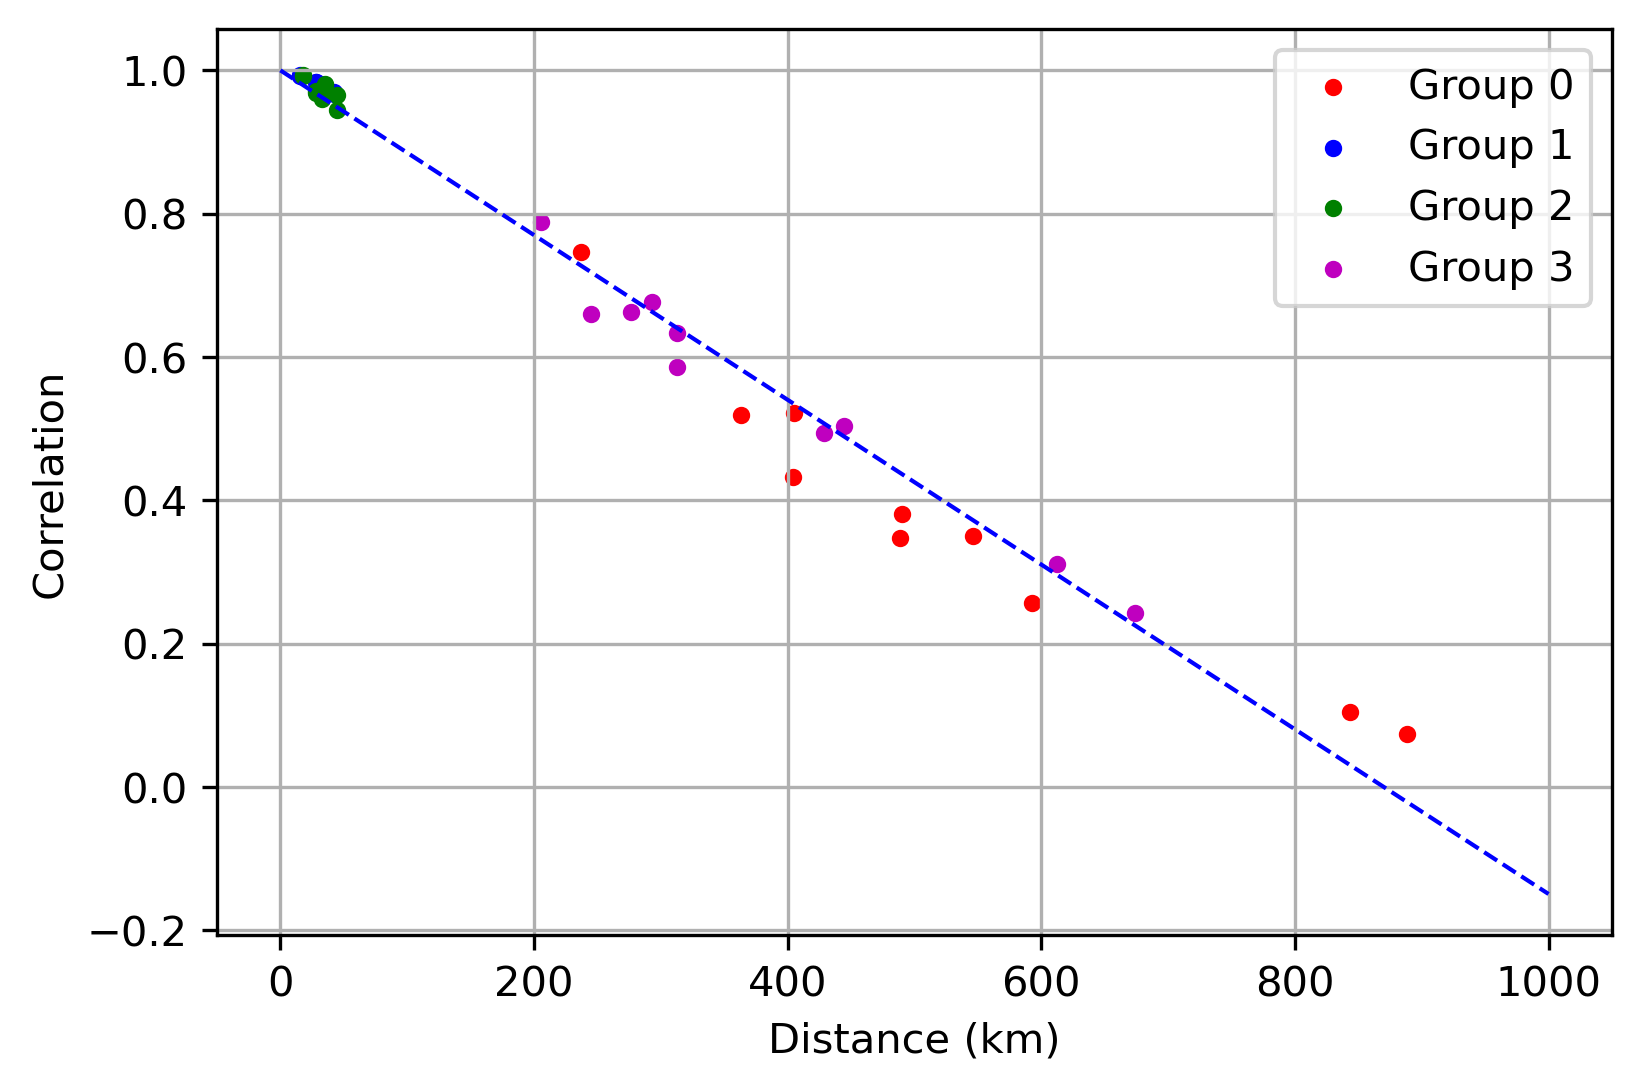

In [21]:
#exponential fit
x = np.linspace(0,1000,num=100)
y = (x/1400)**2 - 0.0015*x + 1
y = 1.1**(-x/60)
y = -x/870 + 1

print('Rank avg:',(np.average(ranks[0,:])+1)/2)

plt.figure(dpi=300)
for i in range(coords.shape[0]):
    plt.scatter(distances[i,:],ranks[i,:], label=f'Group {i}',color=color[i],s=10)
plt.plot(x,y,color='b',linewidth=1,linestyle='--')
plt.legend()
plt.grid()
#plt.title('Correlation over distance')
plt.xlabel('Distance (km)')
plt.ylabel('Correlation')


plt.savefig('./figures/correlation.pdf',bbox_inches='tight')

# Unavailability

The definition used for unavailability can be created in a code format far more simply than the code below. The code below allows for the calculation of several different measures, including the number of hours of unavailability, therefore the code is useful in analysis but not in actual optimisation as these hourly values are not useful as has been decided.

## Unavailability compared to Firm capacity

In [7]:
start_date = '1998-01-01' #1998-01-01
end_date = '2021-12-31' #2021-12-31
num_yrs = 24 #years
grid_min_limits = np.array([0.1,0.2,0.3,0.4,0.5])
#grid_min_limits = np.linspace(0,1.0,30) #remove this after plotting
store = dict()
store_hours = dict()
storage_limit = 50 #GWh
hours_yr = 365.25*24
unavailable_prop = np.zeros((grid_min_limits.shape[0],coords.shape[0]))
store_above_limit = dict()


#cycle through cutoffs
for k in range(grid_min_limits.shape[0]):
    start = time.time()
    lull_limit = turbine_rating*1000*grid_min_limits[k]*n_turbs_grdpnt*coords.shape[1] #max power to be considered a lull
    #cycle through different wind farm groups
    for j in range(coords.shape[0]):
        store[k,j] = []
        store_hours[k,j] = []
        working_ds = agg_power[j].sel(time=slice(start_date, end_date)).copy()
        working_ds -= lull_limit #difference between output and lull limit, i.e. positive: above limit, negative: below
        working_ds = working_ds.where(working_ds < 0,0)
        working_ds = working_ds.values
        count = 0 
        num_hours = 0
        
        #sums the groups
        for i in working_ds:
            if i.item() == 0:
                if count != 0:
                    store[k,j].append(count)
                    store_hours[k,j].append(num_hours)
                    count = 0
                    num_hours = 0
            else:
                count += i.item()
                num_hours += 1
        if count != 0:
            store[k,j].append(count)
            store_hours[k,j].append(num_hours)
            
        store[k,j] = np.abs(np.array(store[k,j]))/1e6 #abs val and changing units
        store_hours[k,j] = np.sum(np.where(store[k,j] >= storage_limit,store_hours[k,j],0))
        unavailable_prop[k,j] = store_hours[k,j]/(hours_yr*num_yrs)
    end = time.time()
    print('Cut-off variation',k,', Time taken:',np.round(end-start,decimals=3),'secs \n')
    
print('Unavailable proportion:',np.round(unavailable_prop[0,0],decimals=5),
      np.round(unavailable_prop[1,0],decimals=5),np.round(unavailable_prop[2,0],decimals=5))

Cut-off variation 0 , Time taken: 0.523 secs 

Cut-off variation 1 , Time taken: 0.551 secs 

Cut-off variation 2 , Time taken: 0.587 secs 

Cut-off variation 3 , Time taken: 0.631 secs 

Cut-off variation 4 , Time taken: 0.657 secs 

Unavailable proportion: 0.0 0.01637 0.08948


Group 0:
Proportion of Unavailability out of the year: 2.148
Proportion of Unavailability out of the year: 4.913
Proportion of Unavailability out of the year: 8.282
Unavailable proportion: 0.08948 4.91285 8.28211


ValueError: x and y must have same first dimension, but have shapes (3,) and (1000,)

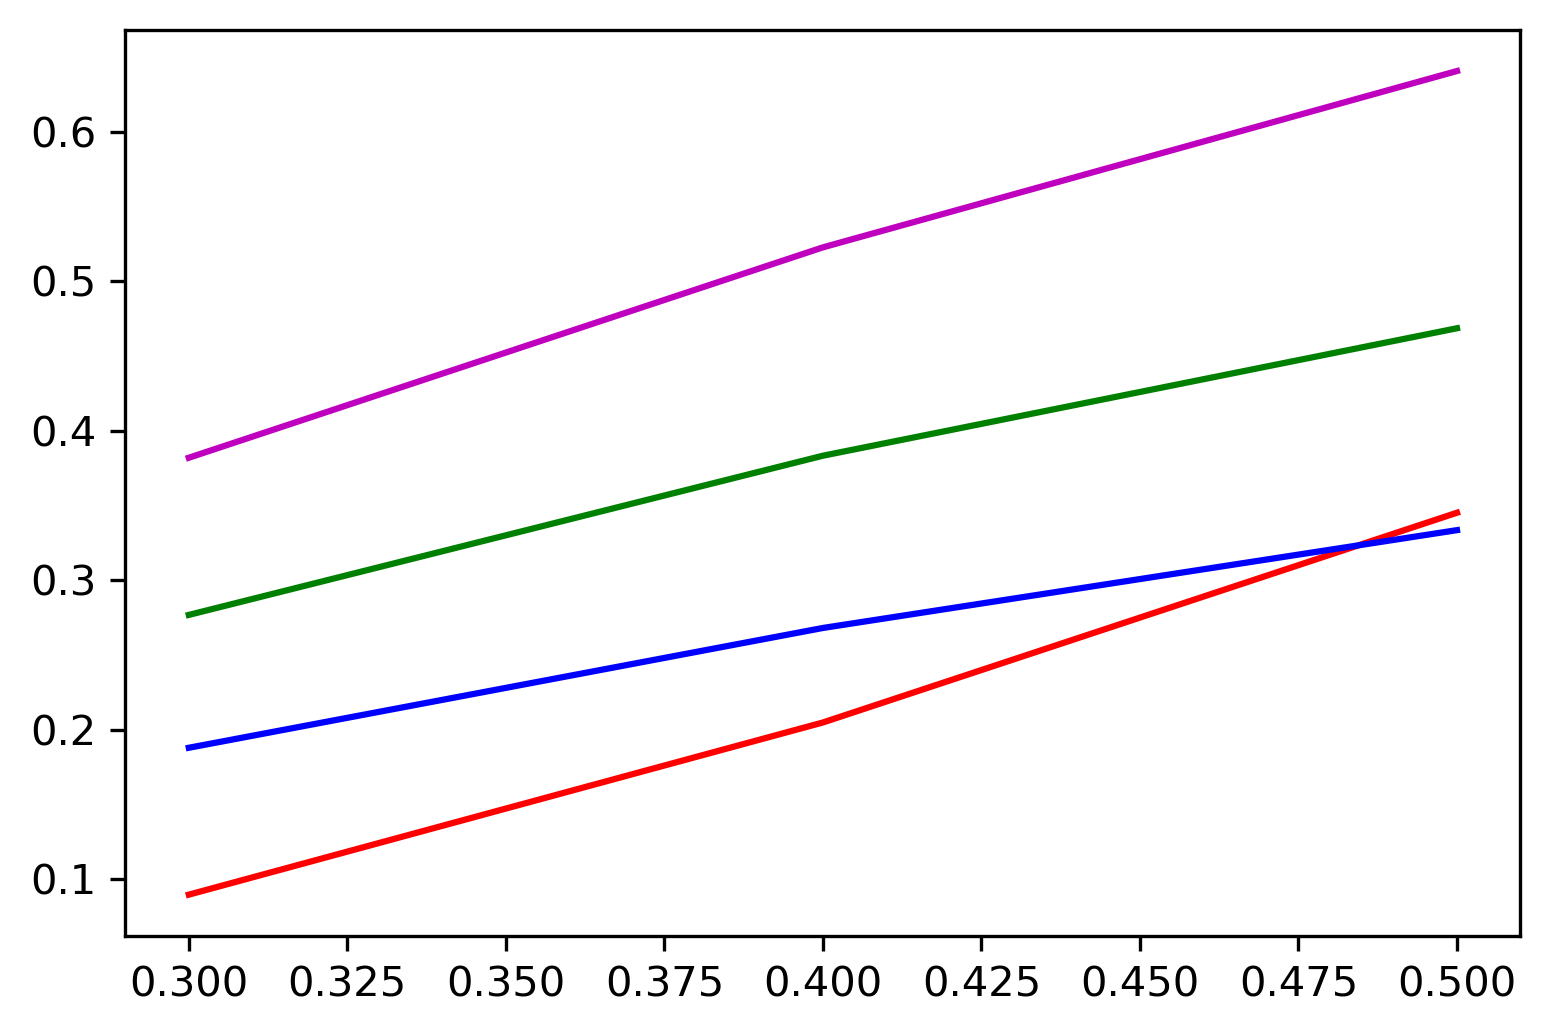

In [23]:
print('Group 0:')
print('Proportion of Unavailability out of the year:',np.round(store_hours[0,0]/hours_yr,decimals=3))
print('Proportion of Unavailability out of the year:',np.round(store_hours[1,0]/hours_yr,decimals=3))
print('Proportion of Unavailability out of the year:',np.round(store_hours[2,0]/hours_yr,decimals=3))

print('Unavailable proportion:',np.round(store_hours[0,0]/(365.25*24*24),decimals=5),
      np.round(store_hours[1,0]/(hours_yr),decimals=5),np.round(store_hours[2,0]/(hours_yr),decimals=5))


scale = 1e-6 #converts kW to GW
plt.figure(dpi=300)
for j in range(coords.shape[0]):
    plt.plot(grid_min_limits, unavailable_prop[:,j],label=f'Firm Cap. {j}',color=color[j])
for j in range(coords.shape[0]):
    plt.plot(grid_min_limits, 1-firm_capacity[j,:],label=f'Unav. {j}',color=color[j],linestyle='--')
plt.ylim(0,1)
#plt.axvline(x= 1, color='red',linestyle='--',linewidth=0.4)
plt.title('Firm Capacity over a range')
plt.title('')
plt.xlabel('Proportion of Capacity')
plt.ylabel('Proportion of time power > proportion of Capacity')
plt.legend()
plt.grid()

plt.savefig('./figures/firm_capacity_range.pdf',bbox_inches='tight')

Unavailability metric seems very similar to the firm capacity ratio, there are small numerical differences, but if we look at the values at 20,30, & 40% of capacity then they are esssentially the same but shifted by a small percentage. It does not seem to gives us any useful information.

## Lull Frequency Histogram

/home/xzcaphbe/.conda/envs/env3.8_optimise/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/xzcaphbe/.conda/envs/env3.8_optimise/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


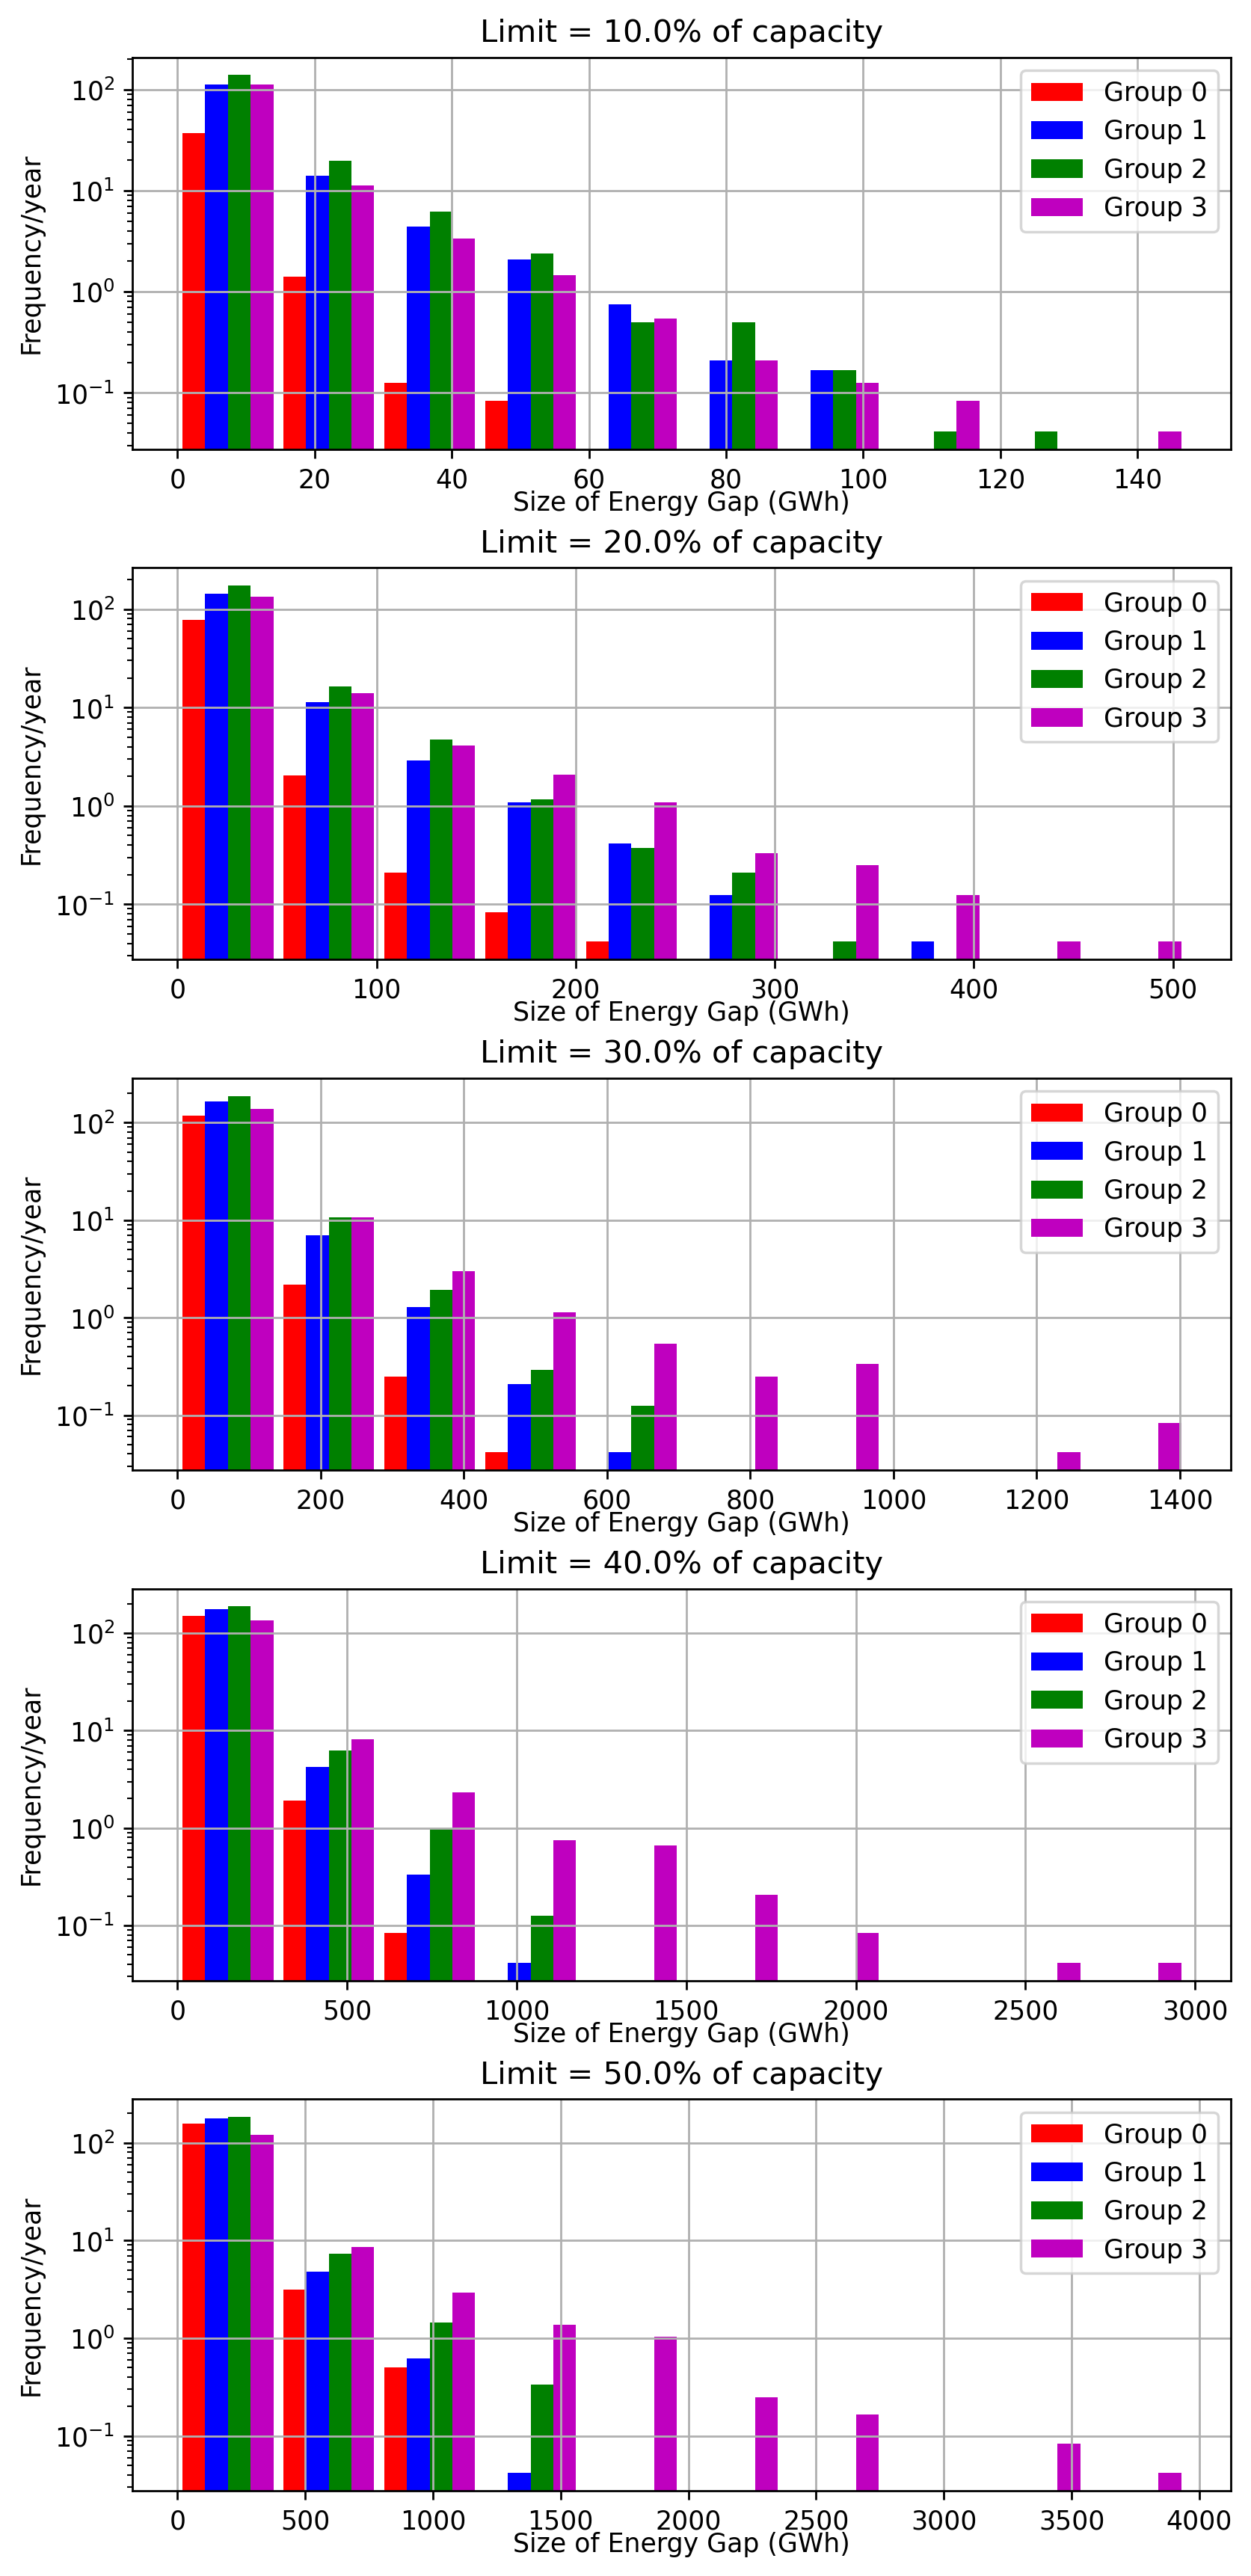

In [8]:
color = ['r','b','g','m']
fig, ax = plt.subplots(grid_min_limits.shape[0],dpi=250, figsize=(7,14*(grid_min_limits.shape[0]/5)))
fig.tight_layout(pad=2.5)
for k in range(grid_min_limits.shape[0]):
    ax[k].set_xlabel('Size of Energy Gap (GWh)',labelpad=-1)
    ax[k].set_ylabel('Frequency/year')
    ax[k].grid()        
    ax[k].hist([store[k,0],store[k,1],store[k,2],store[k,3]],label = ['Group 0','Group 1','Group 2','Group 3',],color=color,rwidth=0.9,
              weights=[np.ones(store[k,0].shape[0])/num_yrs, np.ones(store[k,1].shape[0])/num_yrs, 
                       np.ones(store[k,2].shape[0])/num_yrs, np.ones(store[k,3].shape[0])/num_yrs])
    ax[k].set_yscale('log')
    ax[k].set_title(f'Limit = {grid_min_limits[k]*100}% of capacity')
    ax[k].legend()
fig.savefig('./figures/hist_energy_gap.pdf',bbox_inches='tight')

## Fitness Function - looking for efficiency

In [120]:
#importing dataset
start = time.time()
paths = ['./data/netcdf/80m_full_file.nc']
ds = xr.open_mfdataset(paths, parallel=True,concat_dim='time', data_vars='minimal',combine='nested',
                       coords='minimal',compat='override').load().compute()
ds_mean = ds.mean(dim='time')['wind_mag'].transpose().load().compute()
ds_distances = xr.open_mfdataset("./data/netcdf/UK_coast_distances.nc").compute()

#example solution
coord_sol = np.empty((5,2))
coord_sol[0,:] = np.array([55, 0.])
coord_sol[1,:] = np.array([54.5, -4.3])
coord_sol[2,:] = np.array([50.4, -1.3])
coord_sol[3,:] = np.array([58.3, -5.7])
coord_sol[4,:] = np.array([51.8, 1.5])
coord_sol = (np.round(coord_sol*4, decimals=0)/4)


grdpnt_power = 30*30*6
turbine_rating = 8 #MW
n_turbs_grdpnt = grdpnt_power/turbine_rating
loss_factor = 1 #energy lost due to wind turbines in farms


#correlation function definition
def covariance_gufunc(x, y):
    return ((x - x.mean(axis=-1, keepdims=True)) * (y - y.mean(axis=-1, keepdims=True))).mean(axis=-1)
def pearson_correlation_gufunc(x, y):
    return covariance_gufunc(x, y) / (x.std(axis=-1) * y.std(axis=-1))
def spearman_correlation_gufunc(x, y):
    x_ranks = bottleneck.rankdata(x, axis=-1)
    y_ranks = bottleneck.rankdata(y, axis=-1)
    return pearson_correlation_gufunc(x_ranks, y_ranks)
def spearman_correlation(x, y, dim):
    return xr.apply_ufunc(
        spearman_correlation_gufunc,
        x,
        y,
        input_core_dims=[[dim], [dim]],
        dask="parallelized",
        output_dtypes=[float])


end = time.time()
print('Time taken:',np.round(end-start,decimals=3),'secs')
coord_sol = coord_sol.reshape(coord_sol.shape[0]*2, order='F')
num_farms = int(coord_sol.shape[0]/2)

Time taken: 35.244 secs


### Creating Function

#### Offshore loss
Calculates a loss for each of the offshore wind farms. 
If offshore by more than 50km
- loss of 1.4% for the conversion to HVDC
- loss of 3.5% per 1000km

The losses for each of the farms in the group are then averaged to give a total group loss, which is added on as a factor.

In [121]:
#example solution
coord_sol = np.empty((5,2))
coord_sol[0,:] = np.array([55, 0.])
coord_sol[1,:] = np.array([54.5, -4.3])
coord_sol[2,:] = np.array([50.4, -1.3])
coord_sol[3,:] = np.array([58.3, -5.7])
coord_sol[4,:] = np.array([51.8, 1.5])
coord_sol = (np.round(coord_sol*4, decimals=0)/4)
coord_sol = coord_sol.reshape(coord_sol.shape[0]*2, order='F')

def fitness_func(coord_sol):
    """Fitness function to evaluate the validity of set of wind farm locations."""    
    
    #farm location init.
    num_farms = int(coord_sol.shape[0]/2) #set number of farms
    lats = xr.DataArray(coord_sol[:num_farms], dims='coords')
    lons = xr.DataArray(coord_sol[num_farms:], dims='coords')
    onshore = (ds_mean.sel(latitude = lats, longitude = lons) < 7.6)
    num_onshore_farms = onshore.sum().item() #number of onshore farm 
    agg_power = ((ds['power']
                     .sel(latitude = lats, longitude = lons)*n_turbs_grdpnt*loss_factor)
                     .sum(dim='coords')).compute()
    
    #capacity factor (time averaged power factor)
    num_yrs = 24 #years
    total_capacity = 8000 * n_turbs_grdpnt * num_farms #kW
    total_output = agg_power.sum()
    avg_output = total_output / (num_yrs * 24*365.25)
    capacity_factor = avg_output.item()/total_capacity
    
    #loss factor for offshore farms
    offshore = np.logical_not(onshore)
    farm_distances = ds_distances.sel(latitude = lats, longitude = lons)
    offshore_dists = farm_distances.where(offshore)
    offshore_dists_far = offshore_dists.where(offshore_dists > 50)
    num_far_offshore_farms = offshore_dists_far.count().to_array().to_numpy()[0]
    offshore_cable_loss = (offshore_dists_far/1000)*0.035 #cable loss
    offshore_loss_avg = 1 - ((offshore_cable_loss.sum().to_array().to_numpy()[0]+0.014*num_far_offshore_farms)
                         /(num_farms)) #avg loss, converts to % and adds conversion loss
    

    #correlation init.
    combinations = int(num_farms*(num_farms-1)/2)
    ranks = xr.DataArray(np.zeros((combinations)))
    distances = np.zeros(combinations)

    #firm capacity init.
    ratios = np.array([0.3,0.4,0.5])
    power_limit = ratios * 8000 * n_turbs_grdpnt * num_farms
    firm_capacity = np.empty((ratios.shape[0]))
    unavailable_prop = np.empty((ratios.shape[0]))
    arr_length = agg_power.shape[0]

    #unavailable init.
    store = dict()
    store_hours = dict()
    storage_limit = 50 #GWh
    store_above_limit = dict()

    for i in range(power_limit.shape[0]):

        ##unavailable##
        store[i] = []
        store_hours[i] = []
        working_ds = agg_power.copy() - power_limit[i]  
        working_ds = working_ds.where(working_ds < 0,0).values
        count = 0 
        num_hours = 0
        #sums the groups
        for j in working_ds:
            if j.item() == 0:
                if count != 0:
                    store[i].append(count)
                    store_hours[i].append(num_hours)
                    count = 0
                    num_hours = 0
            else:
                count += j.item()
                num_hours += 1
        if count != 0:
            store[i].append(count)
            store_hours[i].append(num_hours)
        store[i] = np.abs(np.array(store[i]))/1e6
        store_hours[i] = np.sum(np.where(store[i] >= storage_limit,store_hours[i],0))
        unavailable_prop[i] = store_hours[i]/(8760*24)


        ##firm capacity##
        working_ds = agg_power
        val = working_ds.where(working_ds>=power_limit[i]).count(dim='time').values
        firm_capacity[i] = val/arr_length #proportion of values above the power limit

    ##correlation##           
    count = 0
    #cycle through wind farms
    for i in range(num_farms):
        for j in range(i):
            array1 = ds['power'].sel(latitude = coord_sol[i], longitude = coord_sol[num_farms+i]).compute()
            array2 = ds['power'].sel(latitude = coord_sol[j], longitude = coord_sol[num_farms+j]).compute()
            val = spearman_correlation(array1, array2, 'time')
            ranks[count] = val
            loc1=(coord_sol[i],coord_sol[num_farms+i])
            loc2=(coord_sol[j],coord_sol[num_farms+j])
            distances[count] = hs.haversine(loc1,loc2) 
            count += 1
            del array1
            del array2
    ranks = ranks.to_numpy()
    rank = (np.average(ranks)+1)/2 #0 to 1
    
    
    #better = larger
    fitness = ((1-rank) * np.average(firm_capacity) * (1 - np.average(unavailable_prop))  
               * 1.0**num_onshore_farms * offshore_loss_avg *capacity_factor)
    
    print('Unavailable prop:',unavailable_prop[:])
    print('Firm capacity:',firm_capacity[:])
    print('Avg. correlation:',rank)
    print('Offshore loss:',offshore_loss_avg)
    print('Capacity factor:',capacity_factor)
    print('Fitness:',fitness)
    
    return fitness
    

## Calculating Fitness for obviously bad variables

In [122]:
fitness = dict()

for i in range(coords.shape[0]):
    print('\n Group:',i)
    coord_sol = coords[i,:,:]
    coord_sol = (np.round(coord_sol*4, decimals=0)/4)
    coord_sol = coord_sol.reshape(coord_sol.shape[0]*2, order='F')
    fitness[i] = fitness_func(coord_sol)


 Group: 0
Unavailable prop: [0.11918284 0.2224981  0.33885084]
Firm capacity: [0.81459617 0.71162256 0.5997747 ]
Avg. correlation: 0.6977824921566929
Offshore loss: 0.9967220083392233
Capacity factor: 0.5829928684057089
Fitness: 0.09621986531998356

 Group: 1
Unavailable prop: [0.2410626  0.30658771 0.35853786]
Firm capacity: [0.70154099 0.64807685 0.60060176]
Avg. correlation: 0.9891011512333164
Offshore loss: 0.9831555414739492
Capacity factor: 0.6176513210693392
Fitness: 0.003002789506637196

 Group: 2
Unavailable prop: [0.3238632  0.41415525 0.48379471]
Firm capacity: [0.60675717 0.53507396 0.47577763]
Avg. correlation: 0.9863177320281842
Offshore loss: 1.0
Capacity factor: 0.5047250176805446
Fitness: 0.0022070963533366026

 Group: 3
Unavailable prop: [0.38601123 0.51455004 0.62076674]
Firm capacity: [0.54741805 0.4351329  0.33930337]
Avg. correlation: 0.7736786584518024
Offshore loss: 1.0
Capacity factor: 0.39613871624091956
Fitness: 0.019470886825885398


In [125]:
# coords123 = np.array([ 49.,62.25,  56.25,  54.5,   61.75, -11.,   -12.5,  -11.25,   3.,     3.25])
# fitness_func(coords123)
coord_sol = coords[0,:,:]
coord_sol = (np.round(coord_sol*4, decimals=0)/4)
coord_sol = coord_sol.reshape(coord_sol.shape[0]*2, order='F')
print(coord_sol)

[55.   54.5  50.5  58.25 51.75  0.   -4.25 -1.25 -5.75  1.5 ]


## Depth

In [12]:
#importing dataset
paths = ['./data/netcdf/80m_full_file.nc']
ds = xr.open_mfdataset(paths, parallel=False,concat_dim='time', data_vars='minimal',combine='nested',
                       coords='minimal',compat='override').compute().load()
ds_mean = ds.mean(dim='time')['wind_mag'].transpose().compute().load() #finding averages
ds_distances = xr.open_mfdataset("./data/netcdf/UK_coast_distances.nc").compute()
ds_sum = ds.sum(dim='time')
paths = ['./data/depth_map.nc'] #importing depth dataset
ds_depth = xr.open_mfdataset(paths,concat_dim='time', data_vars='minimal',combine='nested',coords='minimal',compat='override').compute()

#implement a preloading of summed data for total figures

grdpnt_power = 30*30*6
turbine_rating = 8 #MW
n_turbs_grdpnt = grdpnt_power/turbine_rating
loss_factor = 0.9 #energy lost due to wind turbines in farms


#correlation function definition
def covariance_gufunc(x, y):
    return ((x - x.mean(axis=-1, keepdims=True)) * (y - y.mean(axis=-1, keepdims=True))).mean(axis=-1)
def pearson_correlation_gufunc(x, y):
    return covariance_gufunc(x, y) / (x.std(axis=-1) * y.std(axis=-1))
def spearman_correlation_gufunc(x, y):
    x_ranks = bottleneck.rankdata(x, axis=-1)
    y_ranks = bottleneck.rankdata(y, axis=-1)
    return pearson_correlation_gufunc(x_ranks, y_ranks)
def spearman_correlation(x, y, dim):
    return xr.apply_ufunc(
        spearman_correlation_gufunc,
        x,
        y,
        input_core_dims=[[dim], [dim]],
        dask="parallelized",
        output_dtypes=[float])

In [138]:
def fitness_func_idx(coord_idx, solution_idx):
    """Fitness function to evaluate the validity of set of wind farm locations."""
    
    #convert indexes to locations
    lat_idx = coord_idx%55
    lat_idx = lat_idx.astype(int)
    lon_idx = (coord_idx-lat_idx)/55
    lon_idx = lon_idx.astype(int)
    lats = np.arange(49,63.0,0.25)[lat_idx]
    lons = np.arange(-12.5,7.5,0.25)[lon_idx]
    coord_sol = np.hstack((lats,lons))
    
    #farm location init.
    num_farms = int(coord_sol.shape[0]/2) #set number of farms
    lats = xr.DataArray(coord_sol[:num_farms], dims='coords')
    lons = xr.DataArray(coord_sol[num_farms:], dims='coords')
    onshore = (ds_mean.sel(latitude = lats, longitude = lons) < 7.6)
    num_onshore_farms = onshore.sum().item() #number of onshore farm 
    agg_power = ((ds['power']
                     .sel(latitude = lats, longitude = lons)*n_turbs_grdpnt*loss_factor)
                     .sum(dim='coords')).compute()
    
    ##depth##
    #relies on preloaded depth dataset of values z > -60m and location space depths in this range aswell
    lats_init = xr.DataArray(coord_sol[:num_farms], dims='coords')
    lons_init = xr.DataArray(coord_sol[num_farms:], dims='coords') 
    farm_depths = ds_depth.sel(lat = lats_init, lon = lons_init,method="nearest", tolerance=0.1)
    farm_depth_arr = farm_depths.to_array().to_numpy()[0]
    depth_factor = np.mean(1 + farm_depth_arr/(60*3)) #comes from 50% increased cost at 60m below sea level, 
    #maximum of 1/3 penalty factor given due to depth
    
    #capacity factor (time averaged power factor)
    num_yrs = 24 #years
    total_capacity = 8000 * n_turbs_grdpnt * num_farms #kW
    total_output = agg_power.sum()
    avg_output = total_output / (num_yrs * 24*365.25)
    capacity_factor = avg_output.item()/total_capacity
    
    #loss factor for offshore farms
    offshore = np.logical_not(onshore)
    farm_distances = ds_distances.sel(latitude = lats, longitude = lons)
    offshore_dists = farm_distances.where(offshore)
    offshore_dists_far = offshore_dists.where(offshore_dists > 50)
    num_far_offshore_farms = offshore_dists_far.count().to_array().to_numpy()[0]
    offshore_cable_loss = (offshore_dists_far/1000)*0.035 #cable loss
    offshore_loss_avg = 1 - ((offshore_cable_loss.sum().to_array().to_numpy()[0]+0.014*num_far_offshore_farms)
                         /(num_farms)) #avg loss, converts to % and adds conversion loss

    #correlation init.
    combinations = int(num_farms*(num_farms-1)/2)
    ranks = xr.DataArray(np.zeros((combinations)))
    distances = np.zeros(combinations)

    #firm capacity init.
    ratios = np.array([0.3,0.4,0.5])
    power_limit = ratios * 8000 * n_turbs_grdpnt * num_farms
    firm_capacity = np.empty((ratios.shape[0]))
    unavailable_prop = np.empty((ratios.shape[0]))
    arr_length = agg_power.shape[0]

    #unavailable init.
    num_yrs = 24 #years
    store = dict()
    store_hours = dict()
    storage_limit = 50 #GWh
    store_above_limit = dict()

    for i in range(power_limit.shape[0]):

        ##unavailable##
        store[i] = []
        store_hours[i] = []
        working_ds = agg_power.copy() - power_limit[i]  
        working_ds = working_ds.where(working_ds < 0,0).values
        count = 0 
        num_hours = 0
        #sums the groups
        for j in working_ds:
            if j.item() == 0:
                if count != 0:
                    store[i].append(count)
                    store_hours[i].append(num_hours)
                    count = 0
                    num_hours = 0
            else:
                count += j.item()
                num_hours += 1
        if count != 0:
            store[i].append(count)
            store_hours[i].append(num_hours)
        store[i] = np.abs(np.array(store[i]))/1e6
        store_hours[i] = np.sum(np.where(store[i] >= storage_limit,store_hours[i],0))
        unavailable_prop[i] = store_hours[i]/(8760*24)


        ##firm capacity##
        working_ds = agg_power
        val = working_ds.where(working_ds>=power_limit[i]).count(dim='time').values
        firm_capacity[i] = val/arr_length #proportion of values above the power limit

    ##correlation##           
    count = 0
    #cycle through wind farms
    for i in range(num_farms):
        for j in range(i):
            array1 = ds['power'].sel(latitude = coord_sol[i], longitude = coord_sol[num_farms+i]).compute()
            array2 = ds['power'].sel(latitude = coord_sol[j], longitude = coord_sol[num_farms+j]).compute()
            val = spearman_correlation(array1, array2, 'time')
            ranks[count] = val
            loc1=(coord_sol[i],coord_sol[num_farms+i])
            loc2=(coord_sol[j],coord_sol[num_farms+j])
            distances[count] = hs.haversine(loc1,loc2) 
            count += 1
            del array1
            del array2
    ranks = ranks.to_numpy()
    rank = (np.average(ranks)+1)/2 #0 to 1
    
    
    #better = larger
    fitness = ((1-rank) * np.average(firm_capacity) * (1 - np.average(unavailable_prop))  
               * 1.0**num_onshore_farms * offshore_loss_avg *capacity_factor * depth_factor)
    
    #print('Unavailable prop:',unavailable_prop[:])
    print('Firm capacity:',firm_capacity[:])
    print('Avg. correlation:',rank)
    print('Offshore loss:',offshore_loss_avg)
    print('Capacity factor:',capacity_factor)
    print('Depth factor:',depth_factor)
    #print('Fitness:',fitness)
    
    return fitness

In [139]:
for i in range(coords.shape[0]):
    print('\n Group:',i)
    coord_sol = coords[i,:,:]
    coord_sol = (np.round(coord_sol*4, decimals=0)/4)
    coord_sol = coord_sol.reshape(coord_sol.shape[0]*2, order='F')
    fitness[i] = fitness_func_idx(coord_sol,1)


 Group: 0
Firm capacity: [0.87033234 0.77912294 0.68537531]
Avg. correlation: 0.7320943722702156
Offshore loss: 0.9702379088117179
Capacity factor: 0.6053497647645364
Depth factor: -6.404999999999999

 Group: 1
Firm capacity: [0.76055689 0.68113069 0.61626835]
Avg. correlation: 0.834409288777124
Offshore loss: 0.9701360148806416
Capacity factor: 0.5888726358348614
Depth factor: -5.748888888888889

 Group: 2


KeyError: "not all values found in index 'longitude'"